In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import os
import math
from datetime import datetime,timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from xgboost import XGBClassifier
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from numpy import where
from imblearn.over_sampling import SMOTE
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from keras.datasets import imdb
from keras import preprocessing
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, GRU,Bidirectional,Conv1D,MaxPooling1D,Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.layers import LSTM
from keras.optimizers import RMSprop
import statsmodels.api as sm
from scipy.integrate import simps

# check version number
import imblearn
font = {'family' : 'normal','size'   : 20}
plt.rc('font', **font)
plt.rc('figure', titlesize=16)


testDays=np.array([[datetime(2018,7,20),datetime(2018,7,13),datetime(2018,7,27),datetime(2018,7,10),datetime(2018,6,22),datetime(2018,7,3),datetime(2018,7,17),datetime(2018,6,25),datetime(2018,7,24)],
           [datetime(2018,7,19),datetime(2018,6,28),datetime(2018,7,20),datetime(2018,7,27),datetime(2018,7,3),datetime(2018,6,22),datetime(2018,7,26),datetime(2018,6,29),datetime(2018,7,13)],
           [datetime(2018,8,16),datetime(2018,8,8),datetime(2018,8,10),datetime(2018,7,30),datetime(2018,8,20),datetime(2018,8,3),datetime(2018,8,1),datetime(2018,8,17),datetime(2018,8,15)],
           [datetime(2018,8,28),datetime(2018,8,15),datetime(2018,8,14),datetime(2018,8,29),datetime(2018,8,20),datetime(2018,8,22),datetime(2018,8,27),datetime(2018,8,21),datetime(2018,8,16)],
           [datetime(2018,9,6),datetime(2018,9,13),datetime(2018,9,18),datetime(2018,9,14),datetime(2018,9,20),datetime(2018,9,11),datetime(2018,9,17),datetime(2018,9,5),datetime(2018,9,4)],
           [datetime(2018,9,18),datetime(2018,9,14),datetime(2018,9,25),datetime(2018,9,13),datetime(2018,10,3),datetime(2018,10,2),datetime(2018,9,27),datetime(2018,9,17),datetime(2018,9,26)],
           [datetime(2018,10,4),datetime(2018,10,9),datetime(2018,9,25),datetime(2018,10,11),datetime(2018,9,26),datetime(2018,10,3),datetime(2018,10,10),datetime(2018,9,27),datetime(2018,10,2)]
           ]).astype(datetime)

testDaysMealNumbers=np.zeros((7,9,2))
for i in range(7):
    for j in range(9):
        tempDay=testDays[i,j]
        testDaysMealNumbers[i,j,0]=tempDay.timetuple().tm_yday
        testDaysMealNumbers[i,j,1]=j

In [6]:
#Separating the test days from normal ones
rootAddressAllData=r'C:\GitHub\STMI-CGM\Selected-38'
rootAddressSanitized=r'C:\GitHub\STMI-CGM\Sanitized38\TestDays_'
os.chdir(rootAddressAllData)

patientName=['38A','38B','38C','38D','38E','38F','38H']

myFiles=os.listdir()

for myFile in myFiles:
    for counter in range(7):
        if(patientName[counter] in myFile):
            currentPatient=counter
            break
    testDayCounter=1
    print(myFile)
    myDf=pd.read_csv(myFile)
    for myColumn in myDf.columns: 
        if myColumn not in ['time','BG','Participant']:
            del myDf[myColumn]
    myDf=myDf.dropna()
    myDf=myDf.drop_duplicates(subset=['time'], keep='last')
    myDf['time']= pd.to_datetime(myDf['time'])
        
    myDf.insert(3,"StandardTest",0)
    for rowCounter in range(0,len(myDf)):
        for counter in range(0,9):
            if myDf.iloc[rowCounter,1].date()==testDays[currentPatient][counter].date():
                myDf.iloc[rowCounter,3]=counter+1
                break

    myDf=myDf[myDf.StandardTest > 0]
    myFileAddress=rootAddressSanitized+patientName[currentPatient]+'.csv'
    myDf.to_csv(myFileAddress,index = False)

overall_spread_sheet_38A.csv
overall_spread_sheet_38B.csv
overall_spread_sheet_38C.csv
overall_spread_sheet_38D.csv
overall_spread_sheet_38E.csv
overall_spread_sheet_38F.csv
overall_spread_sheet_38H.csv


Reading..... TestDays_38A.csv
The BG base line is not found for 176 and we used 80.0001
Patient= TestDays_38A.csv best class prediction threshold= 0.4 best tree number= 9 best max depth= 7 best positive weight= 20.0 best accuracy= 0.87 best recall= 1.0


		 Pred Neg	 Pred Pos 

True Neg	 56		 20 

True Pos	 0		 76 

Specificity= 0.7368421052631579 Sensitivity= 1.0 Accuracy= 0.868421052631579
('Average', 8.2)
('STD', 4.1)
('Min', 15.4)
('Max', 24.2)
('Min Slope', 19.9)
('Max Slope', 19.0)
('Integral Value', 5.0)
('Min Concavity', 4.0)
('Max Concavity', 0.2)
Reading..... TestDays_38B.csv
The BG base line is not found for 200 and we used 80.0001
Patient= TestDays_38B.csv best class prediction threshold= 0.6 best tree number= 4 best max depth= 9 best positive weight= 2.0 best accuracy= 0.99 best recall= 1.0


		 Pred Neg	 Pred Pos 

True Neg	 67		 1 

True Pos	 0		 67 

Specificity= 0.9852941176470589 Sensitivity= 1.0 Accuracy= 0.9925925925925926
('Average', 5.5)
('STD', 6.8)
('Min', 27.5)

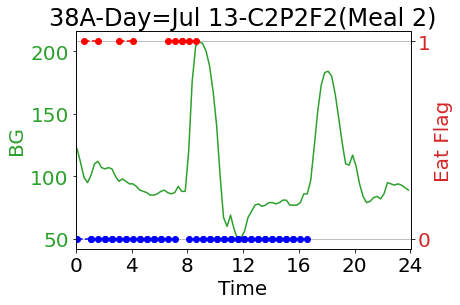

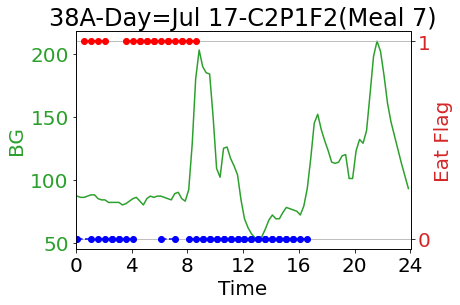

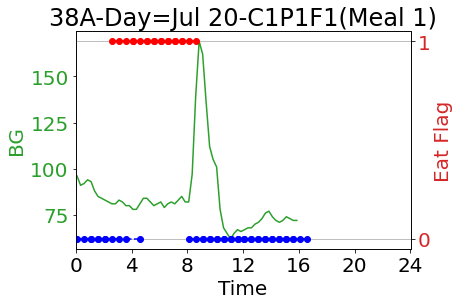

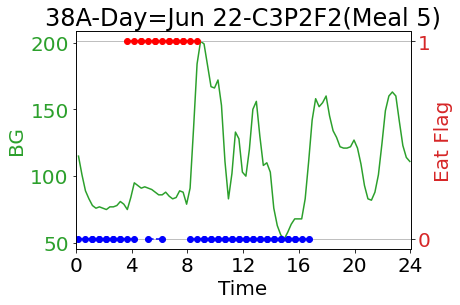

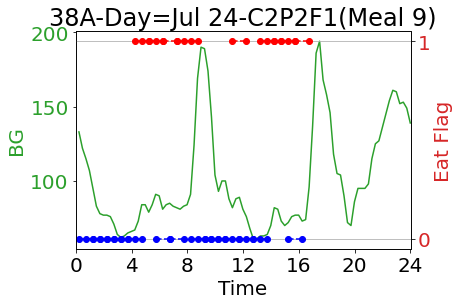

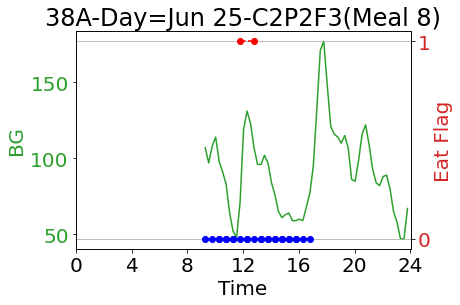

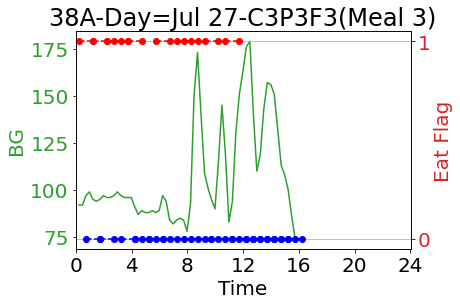

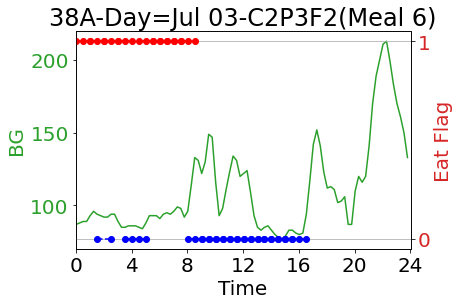

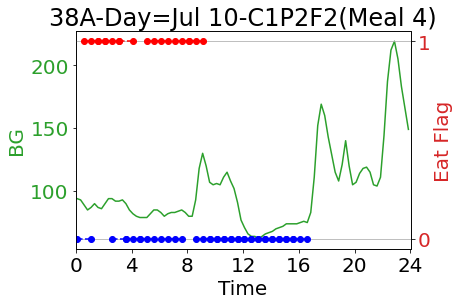

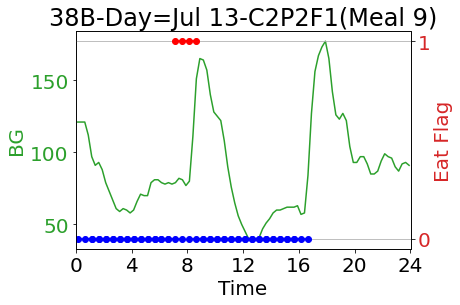

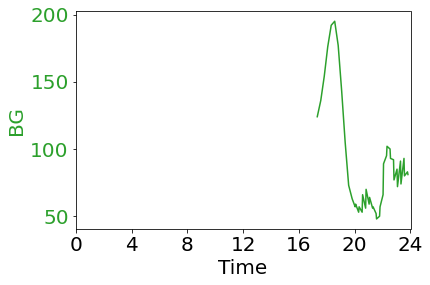

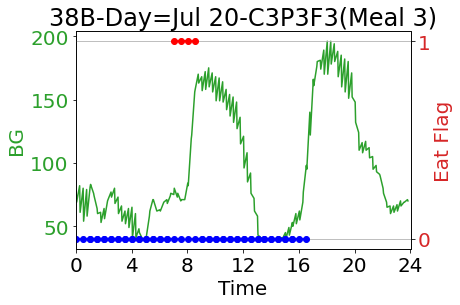

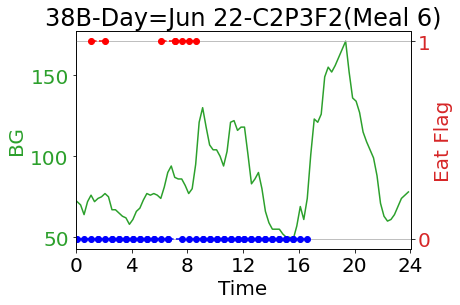

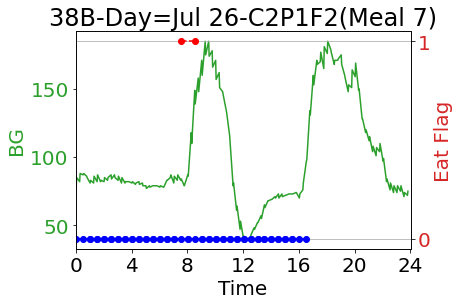

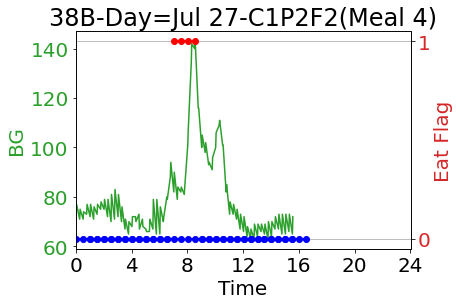

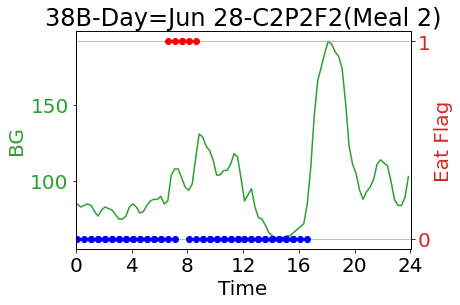

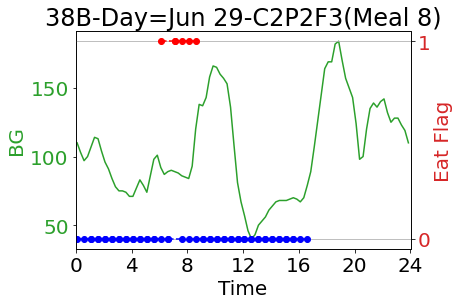

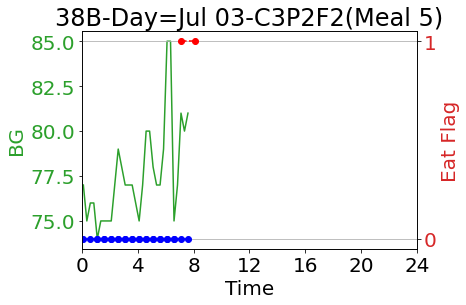

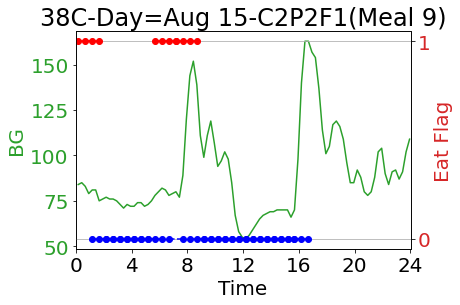

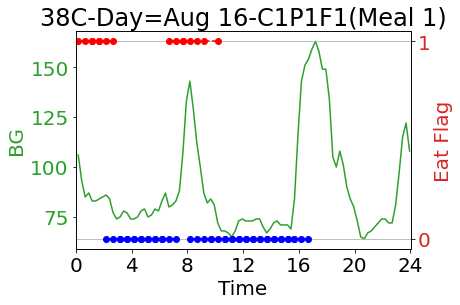

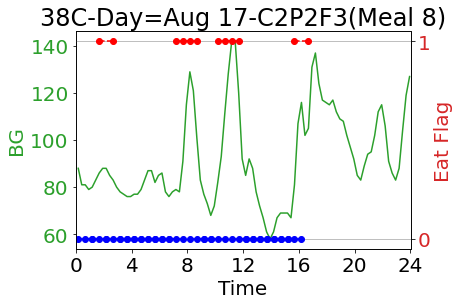

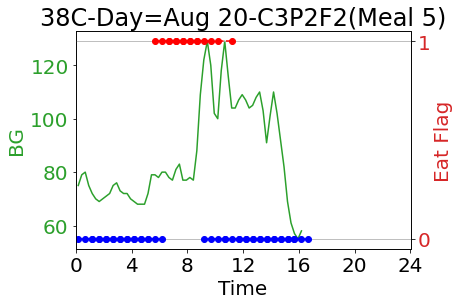

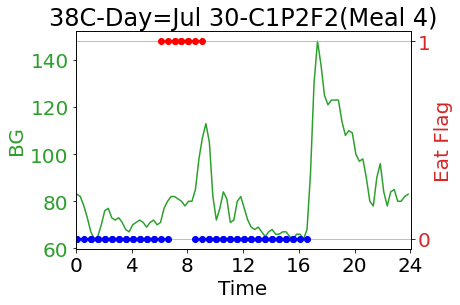

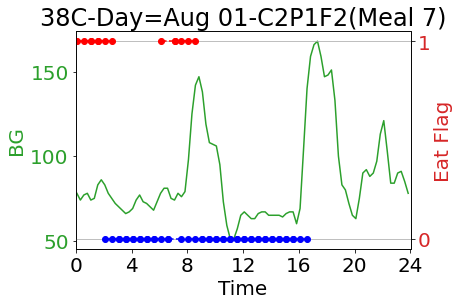

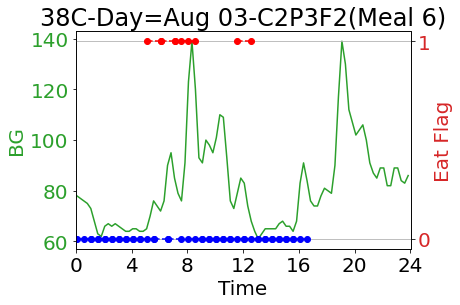

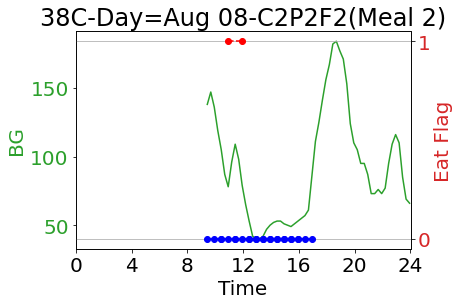

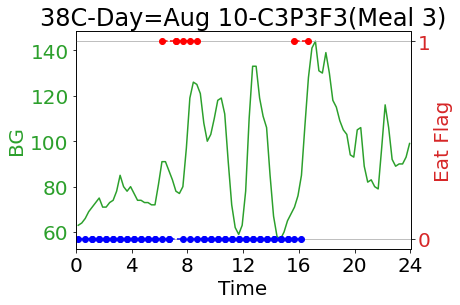

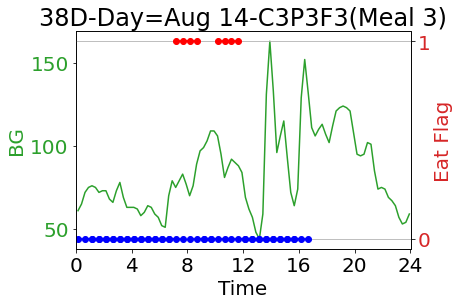

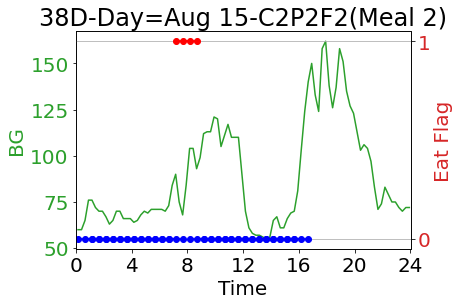

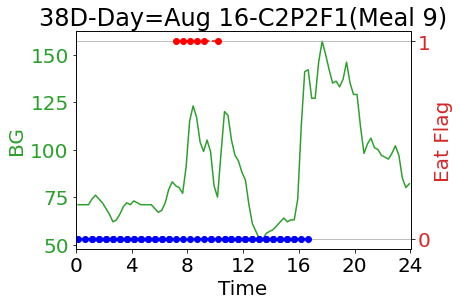

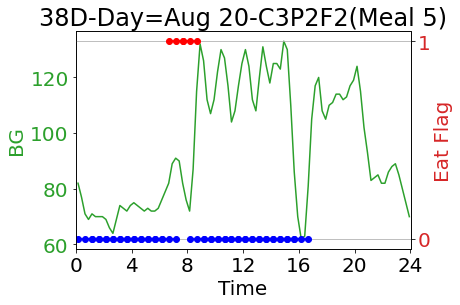

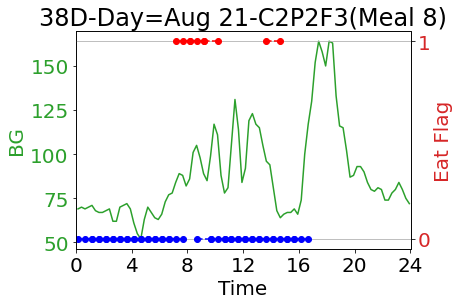

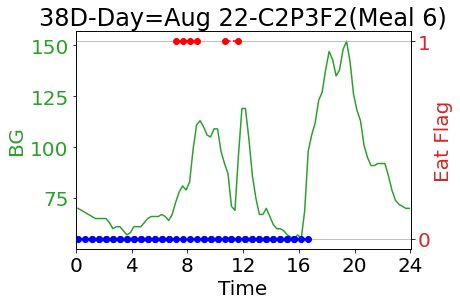

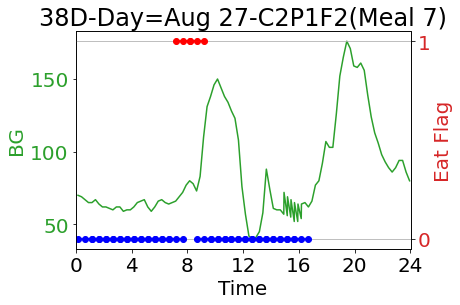

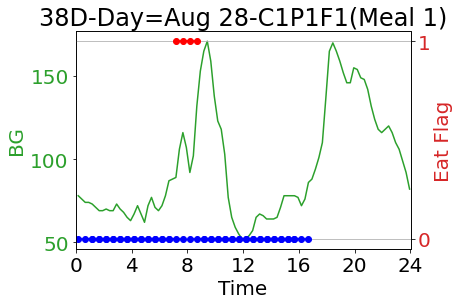

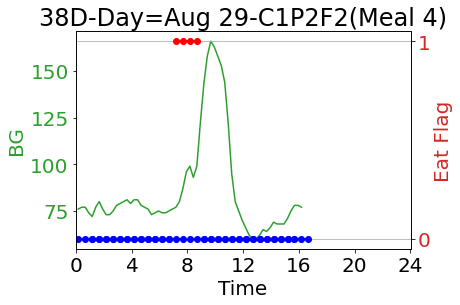

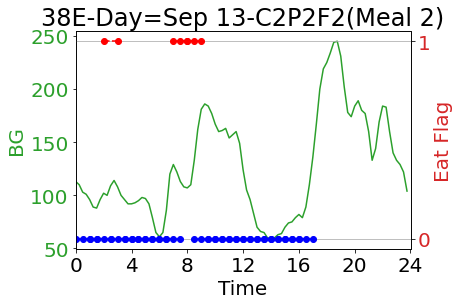

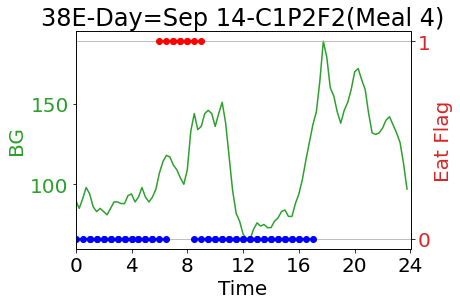

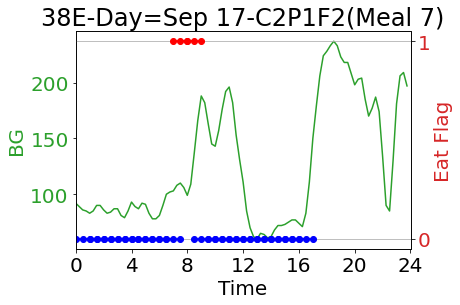

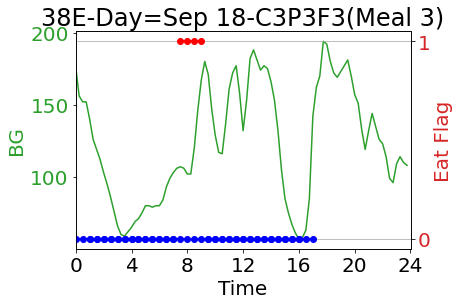

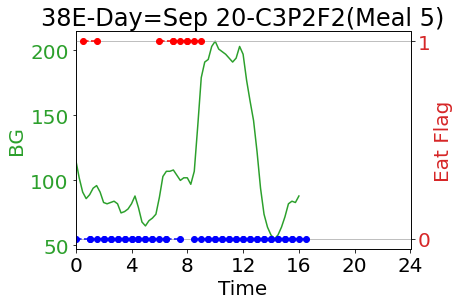

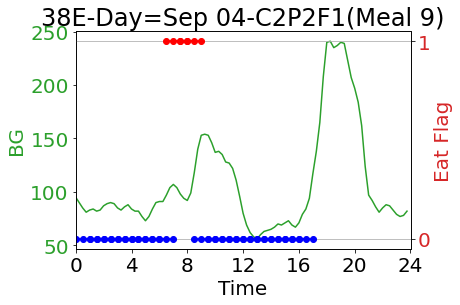

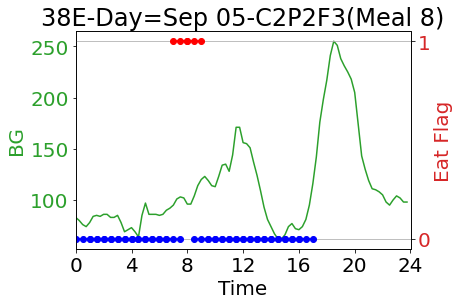

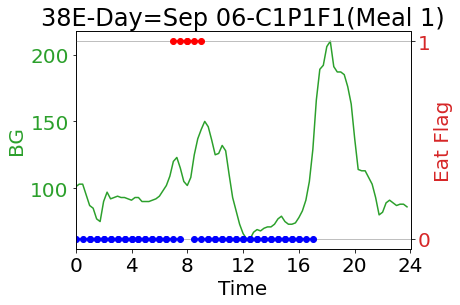

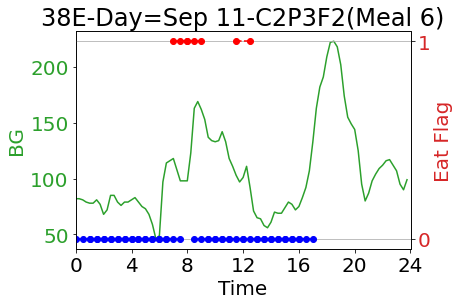

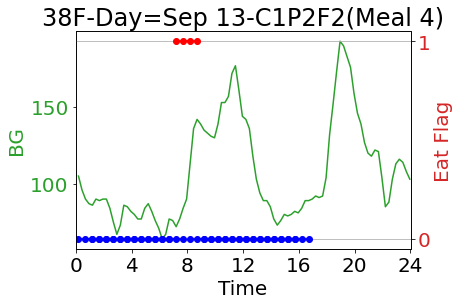

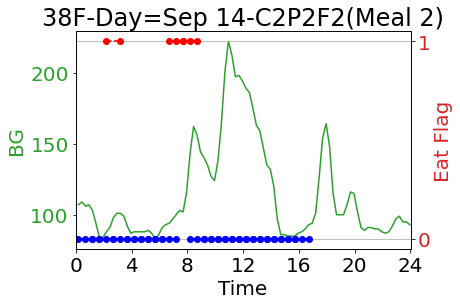

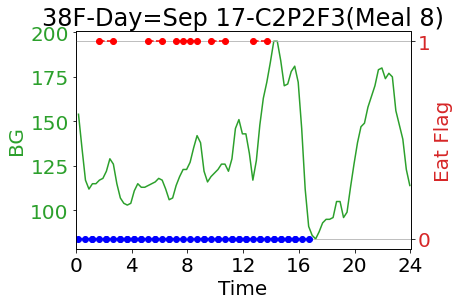

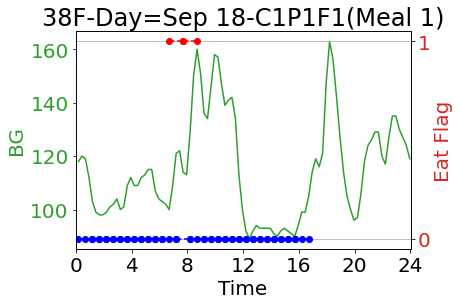

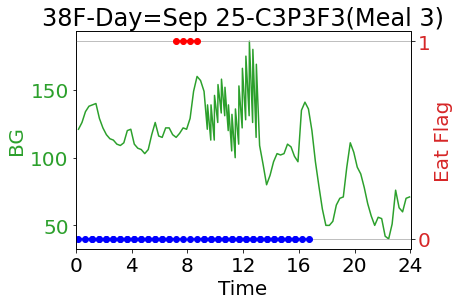

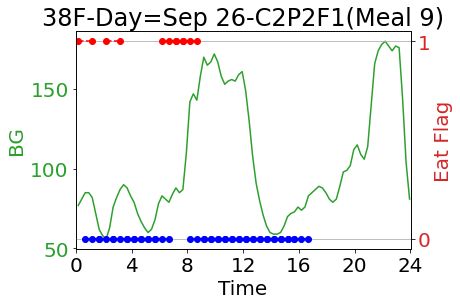

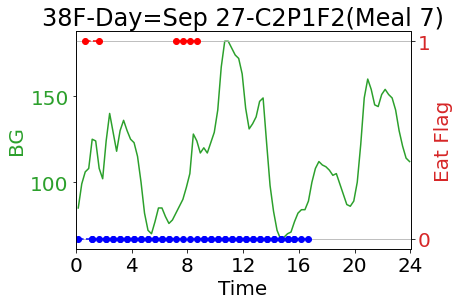

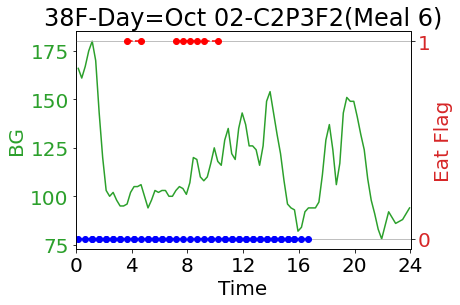

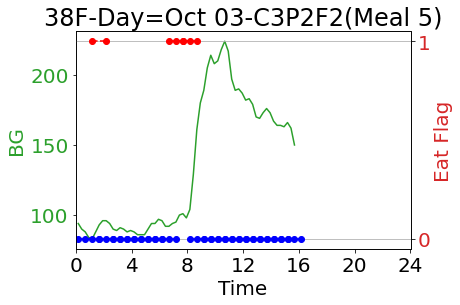

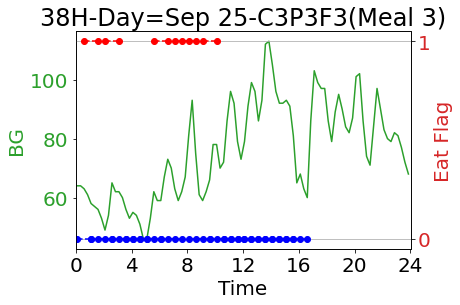

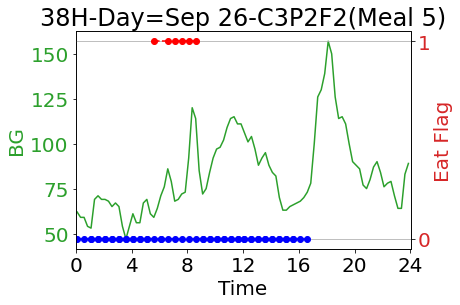

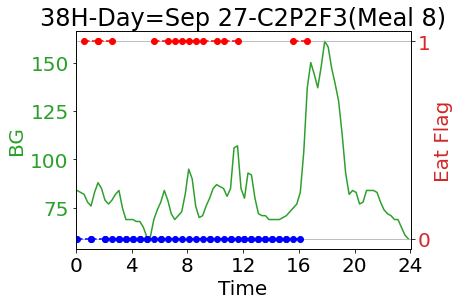

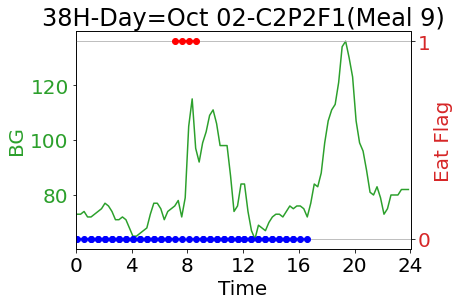

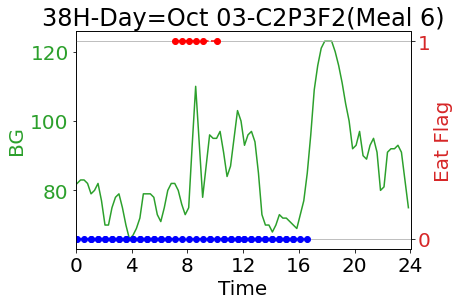

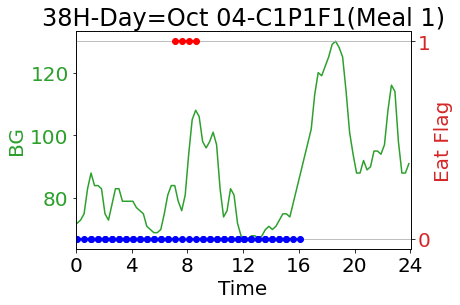

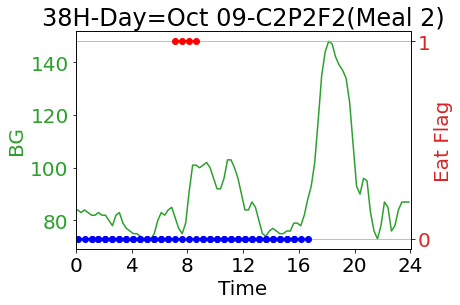

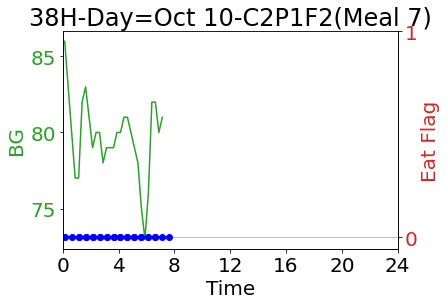

In [34]:
#Running the Random Forest and XGBoost functions
#This is the older version of the Algorithm which uses time window rather than point number
def STMI_random_forest(trains_data_func,test_data_func,train_labels_func,test_labels_func,patient_name_func):
    best_tree_number=-1;
    best_max_depth=-1;
    best_accuracy=-1;
    best_recall=-1;
    best_positive_weight=-1;
    best_confusion_matrix=[];
    for threshold_counter in np.arange(0.4,0.8,0.2):
        threshold_counter=round(threshold_counter,2)
        for tree_number_counter in np.arange(3,10):
            for max_depth_counter in np.arange(3,10):
                for positive_weight_counter in np.arange(1,4,0.5):
                    treeNumber=tree_number_counter
                    maxDepth=max_depth_counter
                    positive_weight=0.2*10**positive_weight_counter

                    clf=RandomForestClassifier(n_estimators=treeNumber,criterion='entropy',random_state=0,max_depth=maxDepth,class_weight={0: 1, 1: positive_weight})
                    clf.fit(trains_data_func,train_labels_func)
                    sliddingWindowPrediction=clf.predict_proba(test_data_func)
                    sliddingWindowPrediction=sliddingWindowPrediction[:,1]
                    sliddingWindowPrediction[sliddingWindowPrediction>=threshold_counter]=1
                    sliddingWindowPrediction[sliddingWindowPrediction<threshold_counter]=0

                    confusionMatrix=sklearn.metrics.confusion_matrix(test_labels_func,sliddingWindowPrediction);
                    accuracy_score_value=sklearn.metrics.accuracy_score(test_labels_func,sliddingWindowPrediction);
                    recall_score_value=sklearn.metrics.recall_score(test_labels_func,sliddingWindowPrediction);            

                    if(accuracy_score_value>=best_accuracy and recall_score_value>=best_recall):
                        best_accuracy=accuracy_score_value;
                        best_recall=recall_score_value;
                        best_tree_number=treeNumber;
                        best_positive_weight=positive_weight;
                        best_max_depth=maxDepth;                
                        best_confusion_matrix=confusionMatrix;
                        best_threshold=threshold_counter
                        best_model=clf


    best_confusion_matrix=[['\t\t','Pred Neg\t','Pred Pos'],['True Neg\t',str(best_confusion_matrix[0,0])+"\t\t",best_confusion_matrix[0,1]],['True Pos\t',str(best_confusion_matrix[1,0])+"\t\t",best_confusion_matrix[1,1]]]
    file_name = "C:\GitHub\STMI-CGM\Sanitized38\RF"+patient_name_func+".pkl"
    pickle.dump(clf, open(file_name, "wb"))

    return best_model,best_threshold,best_tree_number,best_max_depth,best_positive_weight,best_accuracy,best_recall,best_confusion_matrix


def STMI_XGBoost(train_data_func,test_data_func,train_labels_func,test_labels_func,patient_name_func):
    best_eta=-1;
    best_max_depth=-1;
    best_accuracy=-1;
    best_recall=-1;
    best_positive_weight=-1;
    best_confusion_matrix=[];
    for threshold_counter in np.arange(0.4,0.8,0.2):
        threshold_counter=round(threshold_counter,2)
        for eta_counter in np.arange(0.05,0.50,0.05):
            for max_depth_counter in np.arange(3,10):
                for positive_weight_counter in np.arange(1,4,0.5):
                    eta_value=eta_counter;
                    maxDepth=max_depth_counter;
                    positive_weight=0.2*10**positive_weight_counter;

                    model = XGBClassifier(eta=eta_value,max_depth=maxDepth,scale_pos_weight=positive_weight,objective = "binary:logistic",eval_metric = "logloss",use_label_encoder =False);
                    model.fit(train_data_func, train_labels_func);
                    sliddingWindowPrediction = model.predict_proba(test_data_func);
                    sliddingWindowPrediction=sliddingWindowPrediction[:,1]
                    sliddingWindowPrediction[sliddingWindowPrediction>=threshold_counter]=1
                    sliddingWindowPrediction[sliddingWindowPrediction<threshold_counter]=0

                    confusionMatrix=sklearn.metrics.confusion_matrix(test_labels_func,sliddingWindowPrediction);
                    accuracy_score_value=sklearn.metrics.accuracy_score(test_labels_func,sliddingWindowPrediction);
                    recall_score_value=sklearn.metrics.recall_score(test_labels_func,sliddingWindowPrediction);     

                    if(accuracy_score_value>=best_accuracy and recall_score_value>=best_recall):
                        best_accuracy=accuracy_score_value;
                        best_recall=recall_score_value;
                        best_eta=eta_value;
                        best_positive_weight=positive_weight;
                        best_max_depth=maxDepth;                
                        best_confusion_matrix=confusionMatrix; 
                        best_threshold=threshold_counter
        
    best_confusion_matrix=[['\t\t','Pred Neg\t','Pred Pos'],['True Neg\t',str(best_confusion_matrix[0,0])+"\t\t",best_confusion_matrix[0,1]],['True Pos\t',str(best_confusion_matrix[1,0])+"\t\t",best_confusion_matrix[1,1]]]
    file_name = "C:\GitHub\STMI-CGM\Sanitized38\XG"+patient_name_func+".pkl"
    pickle.dump(model, open(file_name, "wb"))    
    return best_threshold,best_eta,best_max_depth,best_positive_weight,best_accuracy,best_recall,best_confusion_matrix;


rootAddress=r"C:\GitHub\STMI-CGM\Sanitized38"
os.chdir(rootAddress)
timeWindow=60/60
timeStep=30/60
breakfastTime=8
myFiles=os.listdir()
mealContent=['C1P1F1','C2P2F2','C3P3F3',
             'C1P2F2','C3P2F2','C2P3F2',
             'C2P1F2','C2P2F3','C2P2F1']
for myFile in myFiles:
    if('.pkl' in myFile):
        continue;
    print('Reading.....',myFile)
    fileAddress=myFile
    if (myFile=='TestDays_38A.csv'):
        testDaysMealNumber=testDaysMealNumbers[0,:,:]
    if (myFile=='TestDays_38B.csv'):
        testDaysMealNumber=testDaysMealNumbers[1,:,:]
    if (myFile=='TestDays_38C.csv'):
        testDaysMealNumber=testDaysMealNumbers[2,:,:]
    if (myFile=='TestDays_38D.csv'):
        testDaysMealNumber=testDaysMealNumbers[3,:,:]
    if (myFile=='TestDays_38E.csv'):
        testDaysMealNumber=testDaysMealNumbers[4,:,:]
    if (myFile=='TestDays_38F.csv'):
        testDaysMealNumber=testDaysMealNumbers[5,:,:]
    if (myFile=='TestDays_38H.csv'):
        testDaysMealNumber=testDaysMealNumbers[6,:,:]

    sliddingWindow=[]
    sliddingWindowResult=[]
    completeSliddingWindow=[]

    raw1=pd.read_csv(fileAddress) 
    raw1['time']= pd.to_datetime(raw1['time'])
    raw1['BG']= pd.to_numeric(raw1['BG'])

    raw1=raw1.dropna()
    raw1=raw1.drop_duplicates(subset=['time'], keep='last')

    raw1.insert(2, "Day of Year",raw1['time'].dt.dayofyear)
    raw1.insert(3, "Time",raw1['time'].dt.hour+raw1['time'].dt.minute/60+raw1['time'].dt.second/3600)
    raw1=raw1.drop(columns=['time'])
    raw1=raw1.sort_values(['Day of Year', 'Time'], ascending=[True, True])
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #     print(raw1)

    allDays=raw1['Day of Year'].tolist()
    allDays=set(allDays)
    allDays=list(allDays)

    for dayCounter in range(len(allDays)):
        currentDay=allDays[dayCounter]
        dayQuery=raw1[raw1['Day of Year']==currentDay]
        startTime=dayQuery.iloc[0,2]
        endTime=startTime+timeWindow
        counter=0;
        baseLine=80.0001;

        baseLineQuery=dayQuery[dayQuery['Time']>=3]
        baseLineQuery=baseLineQuery[baseLineQuery['Time']<=6]

        if(not np.isnan(baseLineQuery.BG.mean())):
            baseLine=baseLineQuery.BG.mean()
        else:
            print("The BG base line is not found for",allDays[dayCounter],"and we used 80.0001")
        windowQuery=dayQuery[dayQuery['Time']>=startTime]
        windowQuery=windowQuery[windowQuery['Time']<endTime]
        while len(windowQuery)>=(timeWindow*4/2):
            if endTime>17:
                break #after 4PM the participants go home and they don't hold the criteria anymore
            if startTime<=breakfastTime and endTime>=breakfastTime:
                eatFlag=1
            else:
                eatFlag=0
            integralValue=simps(windowQuery.iloc[:,3]-baseLine,x=windowQuery.iloc[:,2])

            maxSlopeValue=np.gradient(windowQuery.iloc[:,3]-baseLine,windowQuery.iloc[:,2])
            maxSlopeValue=np.max(maxSlopeValue)

            minSlopeValue=np.gradient(windowQuery.iloc[:,3]-baseLine,windowQuery.iloc[:,2])
            minSlopeValue=np.min(minSlopeValue)

            maxConcavityValue=np.gradient(windowQuery.iloc[:,3]-baseLine,windowQuery.iloc[:,2])
            maxConcavityValue=np.gradient(maxConcavityValue,windowQuery.iloc[:,2])
            # maxConcavityValue=maxConcavityValue[1:-2]
            maxConcavityValue=np.max(maxConcavityValue)

            minConcavityValue=np.gradient(windowQuery.iloc[:,3]-baseLine,windowQuery.iloc[:,2])
            minConcavityValue=np.gradient(minConcavityValue,windowQuery.iloc[:,2])
            # minConcavityValue=minConcavityValue[1:-2]
            minConcavityValue=np.min(minConcavityValue)

            patientName=windowQuery.iloc[0,0]
            meanValue=round(windowQuery['BG'].mean()-baseLine,2)
            stdValue=round(windowQuery['BG'].std(),4)
            minValue=round(windowQuery['BG'].min()-baseLine,2)
            maxValue=round(windowQuery['BG'].max()-baseLine,2)
            minSlopeValue=round(minSlopeValue,4)
            maxSlopeValue=round(maxSlopeValue,4)
            integralValue=round(integralValue,4)
            minConcavityValue=round(minConcavityValue,4)
            maxConcavityValue=round(maxConcavityValue,4)

            sliddingWindow.append([meanValue,stdValue,minValue,maxValue,minSlopeValue,maxSlopeValue,integralValue,minConcavityValue,maxConcavityValue])
            sliddingWindowResult.append(eatFlag)
            completeSliddingWindow.append([meanValue,stdValue,minValue,maxValue,minSlopeValue,maxSlopeValue,integralValue,minConcavityValue,maxConcavityValue,startTime,endTime,currentDay,eatFlag])

            startTime+=timeStep
            endTime+=timeStep
            windowQuery=dayQuery[dayQuery['Time']>=startTime]
            windowQuery=windowQuery[windowQuery['Time']<endTime]

    sliddingWindowResult=np.array(sliddingWindowResult,dtype=int)
    sliddingWindow=np.array(sliddingWindow,dtype=float)
    completeSliddingWindow=np.array(completeSliddingWindow,dtype=float)

    oversample = SMOTE()
    sliddingWindowNew, sliddingWindowResultNew = oversample.fit_resample(sliddingWindow, sliddingWindowResult)

    # fig = plt.figure(figsize=(20, 20))
    # plt.subplot(2, 2, 1)
    # for counter in range(len(sliddingWindowResult)):
    #     if sliddingWindowResult[counter]==0:
    #         plt.scatter(sliddingWindow[counter,0],sliddingWindow[counter,1],c='red')
    # for counter in range(len(sliddingWindowResult)):
    #     if sliddingWindowResult[counter]==1:
    #         plt.scatter(sliddingWindow[counter,0],sliddingWindow[counter,1],c='blue')
    #
    # plt.xlabel("Mean")
    # plt.ylabel("STD")
    # plt.title("Original")
    # plt.scatter([],[],c='blue',label='Positive')
    # plt.scatter([],[],c='red',label='Negative')
    # plt.legend(loc='upper left')
    #
    # plt.subplot(2, 2, 2)
    # for counter in range(len(sliddingWindowResultNew)):
    #     if sliddingWindowResultNew[counter]==0:
    #         plt.scatter(sliddingWindowNew[counter,0],sliddingWindowNew[counter,1],c='red')
    # for counter in range(len(sliddingWindowResultNew)):
    #     if sliddingWindowResultNew[counter]==1:
    #         plt.scatter(sliddingWindowNew[counter,0],sliddingWindowNew[counter,1],c='blue')
    # plt.xlabel("Mean")
    # plt.ylabel("STD")
    # plt.title("SMOTE")
    # plt.scatter([],[],c='blue',label='Positive')
    # plt.scatter([],[],c='red',label='Negative')
    # plt.legend(loc='upper left')

    #
    # fig = plt.figure(figsize=(10, 10))
    # for i in range(6):
    #     for j in range(6):
    #         plt.subplot(6,6,j+i*6+1)
    #         for counter in range(len(sliddingWindowResultNew)):
    #             if sliddingWindowResultNew[counter]==0:
    #                 plt.scatter(sliddingWindowNew[counter,i],sliddingWindowNew[counter,j],c='red')
    #         for counter in range(len(sliddingWindowResultNew)):
    #             if sliddingWindowResultNew[counter]==1:
    #                 plt.scatter(sliddingWindowNew[counter,i],sliddingWindowNew[counter,j],c='blue')

    balancedSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.3,random_state=2)

    for train_index, test_index in balancedSplit.split(sliddingWindowNew, sliddingWindowResultNew):
        train_data, test_data = sliddingWindowNew[train_index], sliddingWindowNew[test_index]
        train_labels, test_labels = sliddingWindowResultNew[train_index], sliddingWindowResultNew[test_index]

    #------------------ Warning possible issue, sliddingWindowNew has 2 dimensions and : should be used(look in the forloop above)

    RF_best_model,RF_best_threshold,RF_best_tree_number,RF_best_max_depth,RF_best_positive_weight,RF_best_accuracy,RF_best_recall,RF_best_confusion_matrix=STMI_random_forest(train_data,test_data,train_labels,test_labels,patientName);
    print("Patient=",myFile,"best class prediction threshold=",RF_best_threshold,"best tree number=",RF_best_tree_number,"best max depth=",RF_best_max_depth,"best positive weight=",round(RF_best_positive_weight,2),"best accuracy=",round(RF_best_accuracy,2),"best recall=",round(RF_best_recall,2))
    print("\n")
    for r in RF_best_confusion_matrix:
        for c in r:
            print(c,end = " ")
        print("\n")
    specificityMet=int(RF_best_confusion_matrix[1][1])/(int(RF_best_confusion_matrix[1][1])+int(RF_best_confusion_matrix[1][2]))
    sensitivityMet=int(RF_best_confusion_matrix[2][2])/(int(RF_best_confusion_matrix[2][1])+int(RF_best_confusion_matrix[2][2]))
    accuracyMet=(int(RF_best_confusion_matrix[1][1])+int(RF_best_confusion_matrix[2][2]))/(int(RF_best_confusion_matrix[1][1])+int(RF_best_confusion_matrix[1][2])
                                                                                 +int(RF_best_confusion_matrix[2][1])+int(RF_best_confusion_matrix[2][2]))
    print("Specificity=",specificityMet,"Sensitivity=",sensitivityMet,"Accuracy=",accuracyMet)

    feat_labels = ['Average','STD','Min','Max','Min Slope', 'Max Slope','Integral Value','Min Concavity','Max Concavity']
    for feature in zip(feat_labels,np.round(RF_best_model.feature_importances_*100,1)):
        print(feature)

    for dayCounter in range(len(allDays)):
        fig, ax1 = plt.subplots()
        newQuery=raw1[raw1['Day of Year']==allDays[dayCounter]]
        # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        #     print("ssssssssssssssssssssssss",newQuery)
        color = 'tab:green'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('BG', color=color)
        ax1.plot(newQuery['Time'],newQuery['BG'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim([0,24])
        ax1.set_xticks(np.arange(0, 26, 4))

        tempData=[]
        for counter in range(completeSliddingWindow.shape[0]):
            if completeSliddingWindow[counter,11]==allDays[dayCounter]:
                tempData.append(completeSliddingWindow[counter,:])
        tempData=np.array(tempData,dtype=float)

        # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            # print("ssssssssssssssssssssssss",newQuery)

        if len(tempData)==0:
            print("--------Warning, the slidding window is empty for prediction on day:",allDays[dayCounter])
            continue

        tempDataResult=tempData[:,-1].astype(int)
        newTemp=tempData[:,0:9]

        tempDataPred=RF_best_model.predict_proba(newTemp)
        tempDataPred=tempDataPred[:,1]
        tempDataPred[tempDataPred>=RF_best_threshold]=1
        tempDataPred[tempDataPred<RF_best_threshold]=0
        newTemp=tempData[:,9:11]

        ax2 = ax1.twinx()
        for counter in range(len(tempDataPred)):
            if tempDataPred[counter]==1:
                ax2.plot(newTemp[counter,:],np.ones((2,1))*tempDataPred[counter], linestyle='--', marker='o', color='r')
            if tempDataPred[counter]==0:
                ax2.plot(newTemp[counter,:],np.ones((2,1))*tempDataPred[counter], linestyle='--', marker='o', color='b')
        for counter in range(9):
            if testDaysMealNumber[counter,0]==allDays[dayCounter]:
                tempMealName=testDaysMealNumber[counter,1]
        tempMealName=int(tempMealName)
        tempDate=datetime(2018, 1, 1) + timedelta(allDays[dayCounter] - 1)
        tempDate=tempDate.strftime("%b %d")

        plt.title(patientName+"-Day="+tempDate+"-"+mealContent[tempMealName]+"(Meal "+str(tempMealName+1)+")",color='black')

        color='tab:red'
        ax2.set_ylabel('Eat Flag', color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yticks([0,1])
        ax2.set_xlim([0,24])
        ax2.set_xticks(np.arange(0, 26, 4))

        plt.grid()
        plt.show()

#     XG_best_threshold,XG_best_eta,XG_best_max_depth,XG_best_positive_weight,XG_best_accuracy,XG_best_recall,XG_best_confusion_matrix=STMI_XGBoost(train_data,test_data,train_labels,test_labels,myFile[myFile.index('_')+1:myFile.index('.')]);
#     print("Patient=",myFile,"best class prediction threshold=",XG_best_threshold,"best eta=",XG_best_eta,"best max depth=",XG_best_max_depth,"best positive weight=",round(XG_best_positive_weight,2),"best accuracy=",round(XG_best_accuracy,2),"best recall=",round(XG_best_recall,2))
#     print("\n")
#     for r in XG_best_confusion_matrix:
#         for c in r:
#             print(c,end = " ")
#         print("\n")

('Average', 6.8)
('STD', 6.2)
('Min', 16.4)
('Max', 25.0)
('Min Slope', 1.1)
('Max Slope', 30.7)
('Integral Value', 13.7)


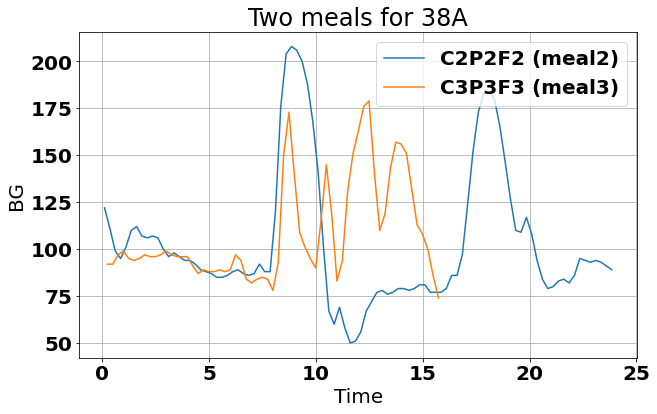

In [266]:
plt.figure(figsize=(10,6))
myQuery=raw1[raw1['Day of Year']==194]
plt.plot(myQuery['Time'],myQuery['BG'])
myQuery=raw1[raw1['Day of Year']==208]
plt.plot(myQuery['Time'],myQuery['BG'])
plt.legend((mealContent[1]+' (meal2)',mealContent[2]+' (meal3)'))
plt.xlabel('Time')
plt.ylabel('BG')
plt.title("Two meals for 38A")
plt.grid()

The BG base line is not found for 200 and we used 80.0001


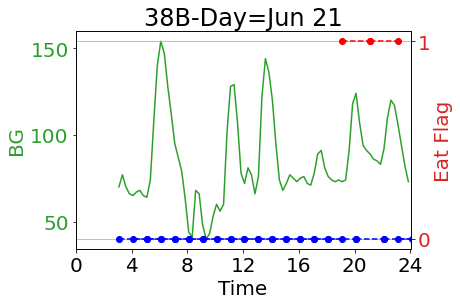

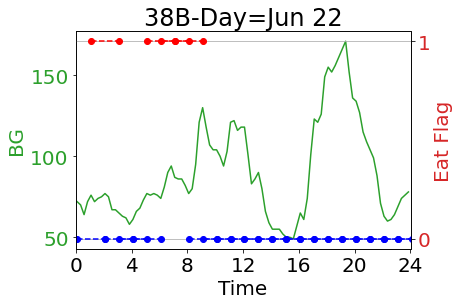

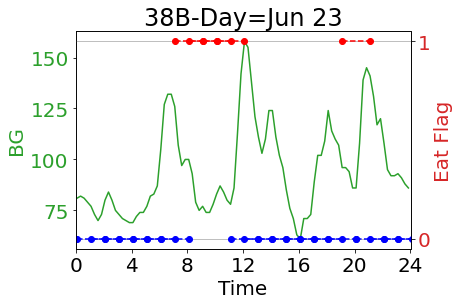

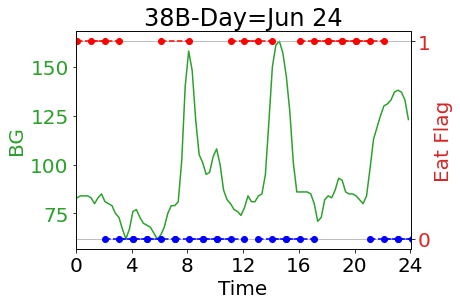

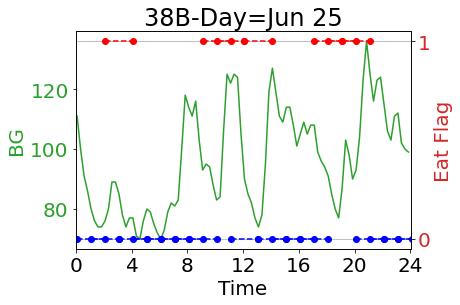

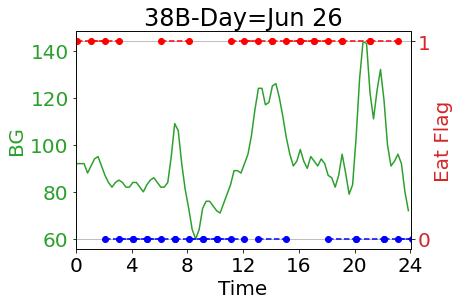

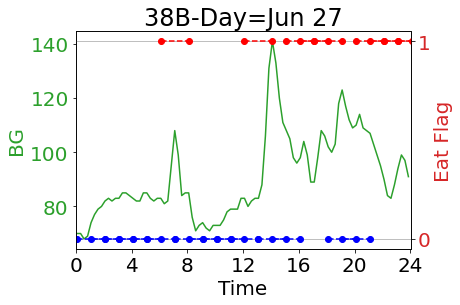

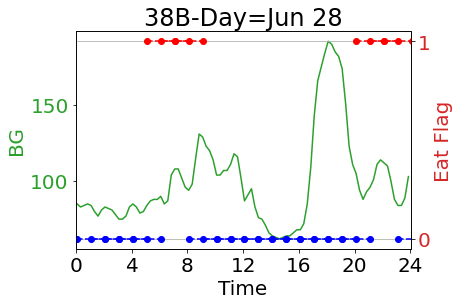

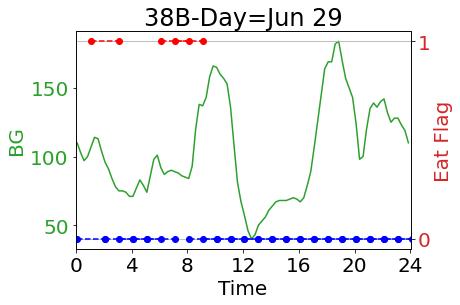

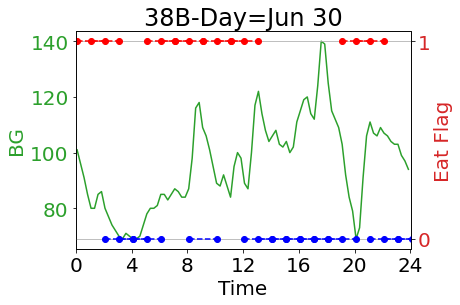

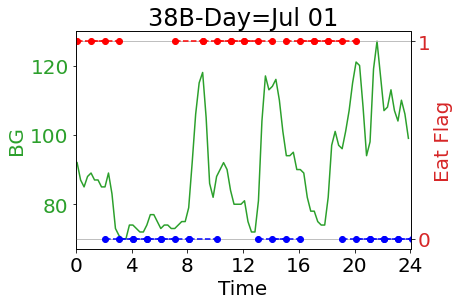

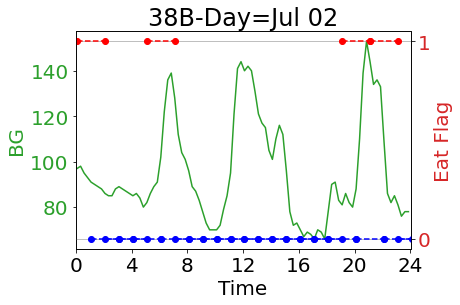

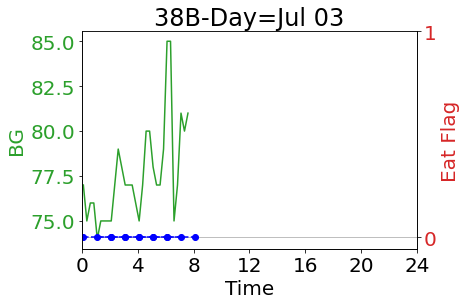

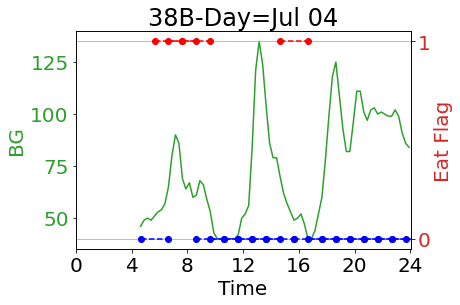

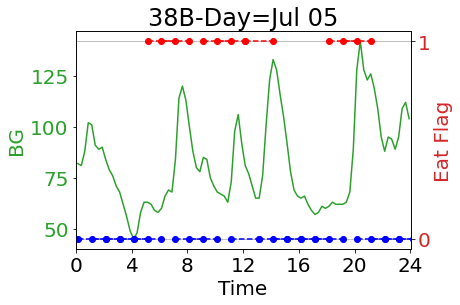

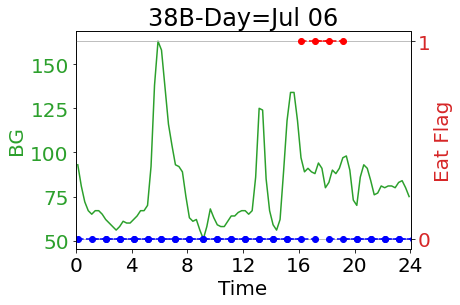

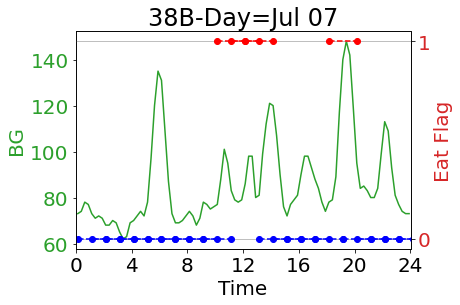

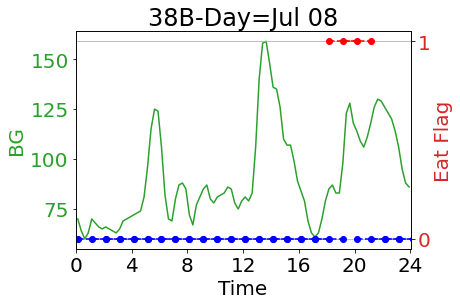

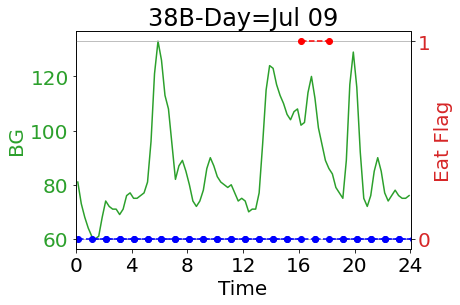

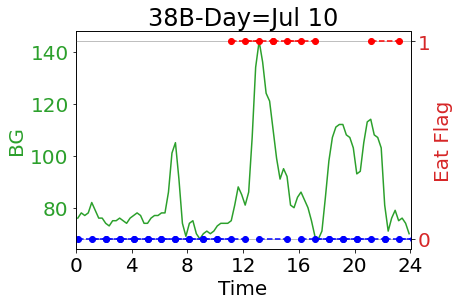

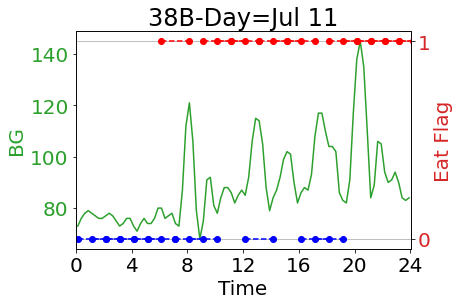

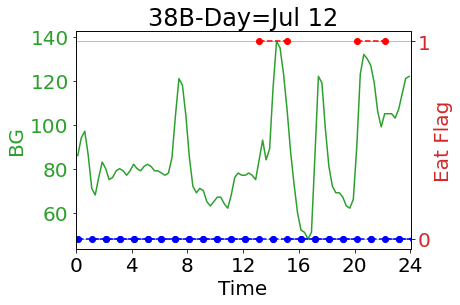

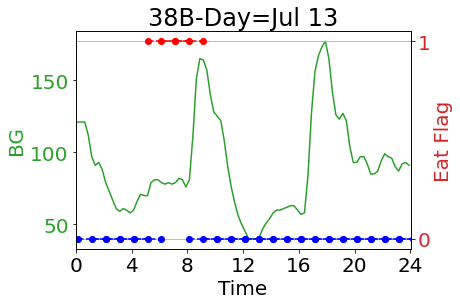

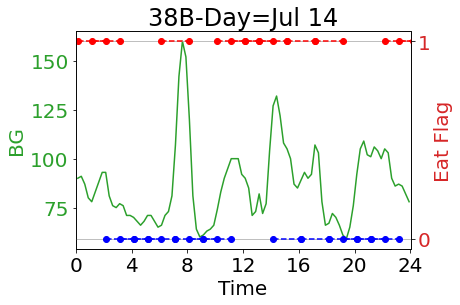

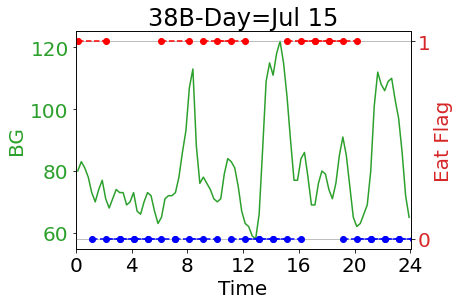

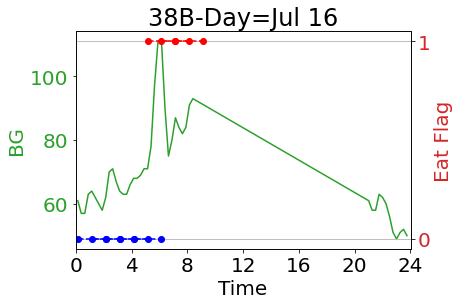

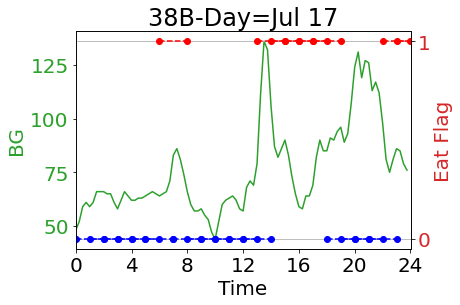

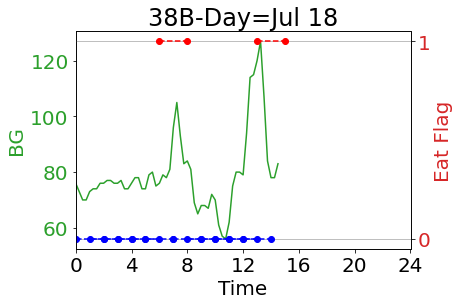

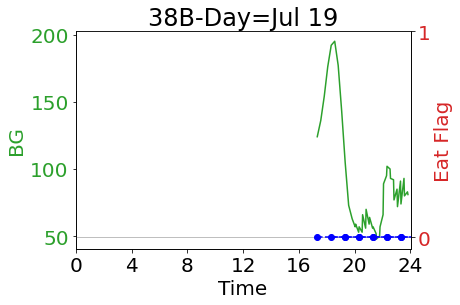

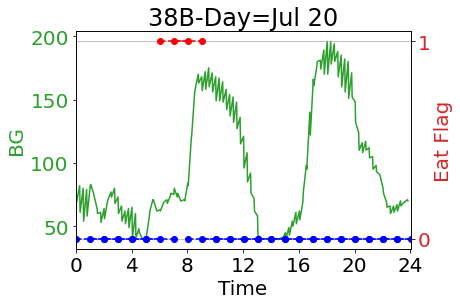

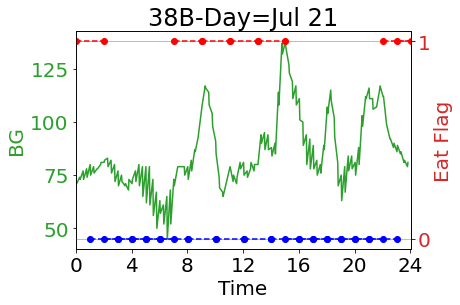

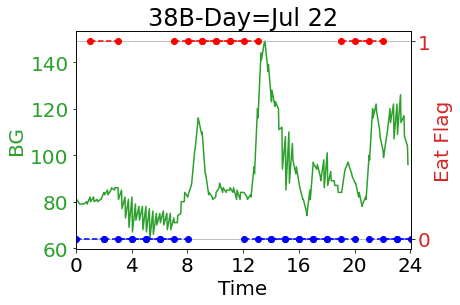

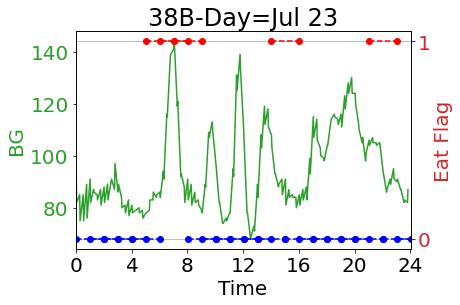

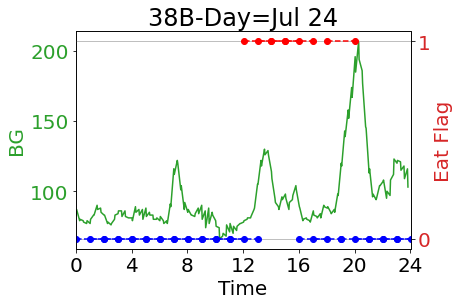

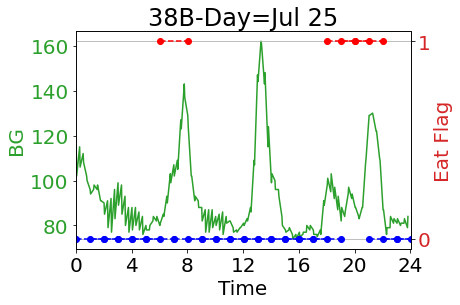

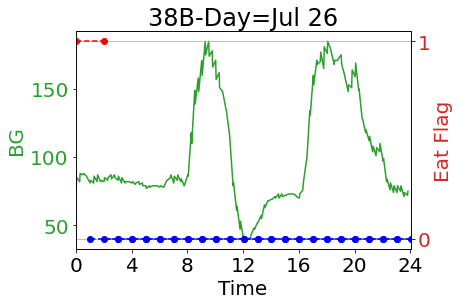

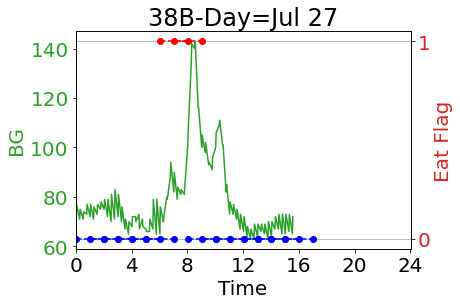

In [32]:
RF_best_threshold=0.6
# timeWindow=120/60
# timeStep=60/60
# breakfastTime=8
myFiles=os.listdir()
mealContent=['C1P1F1','C2P2F2','C3P3F3',
             'C1P2F2','C3P2F2','C2P3F2',
             'C2P1F2','C2P2F3','C2P2F1']

RF_best_model = pickle.load(open(r"C:\GitHub\STMI-CGM\Sanitized38\RF38B.pkl", 'rb'))
fileAddress=r"C:\GitHub\STMI-CGM\38-ALL-data-dump\38B\all_record_38B.csv"

sliddingWindow=[]
sliddingWindowResult=[]
completeSliddingWindow=[]

raw1=pd.read_csv(fileAddress)

raw1['time']= pd.to_datetime(raw1['time'])
raw1['BG']= pd.to_numeric(raw1['BG'])
for myColumn in raw1.columns:
    if myColumn not in ['time','BG','Participant']:
        del raw1[myColumn]

raw1=raw1.dropna()
raw1=raw1.drop_duplicates(subset=['time'], keep='last')

raw1.insert(2, "Day of Year",raw1['time'].dt.dayofyear)
raw1.insert(3, "Time",raw1['time'].dt.hour+raw1['time'].dt.minute/60+raw1['time'].dt.second/3600)
raw1=raw1.drop(columns=['time'])
raw1=raw1.sort_values(['Day of Year', 'Time'], ascending=[True, True])

allDays=raw1['Day of Year'].tolist()
allDays=set(allDays)
allDays=list(allDays)

for dayCounter in range(len(allDays)):
    currentDay=allDays[dayCounter]
    dayQuery=raw1[raw1['Day of Year']==currentDay]
    startTime=dayQuery.iloc[0,2]
    endTime=startTime+timeWindow
    counter=0;
    baseLine=80.0001;

    baseLineQuery=dayQuery[dayQuery['Time']>=3]
    baseLineQuery=baseLineQuery[baseLineQuery['Time']<=6]

    if(not np.isnan(baseLineQuery.BG.mean())):
        baseLine=baseLineQuery.BG.mean()
    else:
        print("The BG base line is not found for",allDays[dayCounter],"and we used 80.0001")
    windowQuery=dayQuery[dayQuery['Time']>=startTime]
    windowQuery=windowQuery[windowQuery['Time']<endTime]
    while len(windowQuery)>=(timeWindow*4/2):
        # if endTime>17:
        #     break #after 4PM the participants go home and they don't hold the criteria anymore
        if startTime<=breakfastTime and endTime>=breakfastTime:
            eatFlag=1
        else:
            eatFlag=0
        integralValue=simps(windowQuery.iloc[:,3]-baseLine,x=windowQuery.iloc[:,2])

        maxSlopeValue=np.gradient(windowQuery.iloc[:,3]-baseLine,windowQuery.iloc[:,2])
        maxSlopeValue=np.max(maxSlopeValue)

        minSlopeValue=np.gradient(windowQuery.iloc[:,3]-baseLine,windowQuery.iloc[:,2])
        minSlopeValue=np.min(minSlopeValue)

        maxConcavityValue=np.gradient(windowQuery.iloc[:,3]-baseLine,windowQuery.iloc[:,2])
        maxConcavityValue=np.gradient(maxConcavityValue,windowQuery.iloc[:,2])
        # maxConcavityValue=maxConcavityValue[1:-2]
        maxConcavityValue=np.max(maxConcavityValue)

        minConcavityValue=np.gradient(windowQuery.iloc[:,3]-baseLine,windowQuery.iloc[:,2])
        minConcavityValue=np.gradient(minConcavityValue,windowQuery.iloc[:,2])
        # minConcavityValue=minConcavityValue[1:-2]
        minConcavityValue=np.min(minConcavityValue)

        patientName=windowQuery.iloc[0,0]
        meanValue=round(windowQuery['BG'].mean()-baseLine,2)
        stdValue=round(windowQuery['BG'].std(),4)
        minValue=round(windowQuery['BG'].min()-baseLine,2)
        maxValue=round(windowQuery['BG'].max()-baseLine,2)
        minSlopeValue=round(minSlopeValue,4)
        maxSlopeValue=round(maxSlopeValue,4)
        integralValue=round(integralValue,4)
        minConcavityValue=round(minConcavityValue,4)
        maxConcavityValue=round(maxConcavityValue,4)

        sliddingWindow.append([meanValue,stdValue,minValue,maxValue,minSlopeValue,maxSlopeValue,integralValue,minConcavityValue,maxConcavityValue])
        sliddingWindowResult.append(eatFlag)
        completeSliddingWindow.append([meanValue,stdValue,minValue,maxValue,minSlopeValue,maxSlopeValue,integralValue,minConcavityValue,maxConcavityValue,startTime,endTime,currentDay,eatFlag])

        startTime+=timeStep
        endTime+=timeStep
        windowQuery=dayQuery[dayQuery['Time']>=startTime]
        windowQuery=windowQuery[windowQuery['Time']<endTime]

sliddingWindowResult=np.array(sliddingWindowResult,dtype=int)
sliddingWindow=np.array(sliddingWindow,dtype=float)
completeSliddingWindow=np.array(completeSliddingWindow,dtype=float)

for dayCounter in range(len(allDays)):
    fig, ax1 = plt.subplots()
    newQuery=raw1[raw1['Day of Year']==allDays[dayCounter]]
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #     print("ssssssssssssssssssssssss",newQuery)
    color = 'tab:green'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('BG', color=color)
    ax1.plot(newQuery['Time'],newQuery['BG'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim([0,24])
    ax1.set_xticks(np.arange(0, 26, 4))

    tempData=[]
    for counter in range(completeSliddingWindow.shape[0]):
        if completeSliddingWindow[counter,11]==allDays[dayCounter]:
            tempData.append(completeSliddingWindow[counter,:])
    tempData=np.array(tempData,dtype=float)

    if len(tempData)==0:
        print("--------Warning, the slidding window is empty for prediction on day:",allDays[dayCounter])
        continue

    tempDataResult=tempData[:,-1].astype(int)
    newTemp=tempData[:,0:9]

    tempDataPred=RF_best_model.predict_proba(newTemp)
    tempDataPred=tempDataPred[:,1]
    tempDataPred[tempDataPred>=RF_best_threshold]=1
    tempDataPred[tempDataPred<RF_best_threshold]=0
    newTemp=tempData[:,9:11]

    ax2 = ax1.twinx()
    for counter in range(len(tempDataPred)):
        # ax2.plot(newTemp[counter,:],np.ones((2,1))*tempDataPred[counter], linestyle='--', marker='o', color='c')
        if tempDataPred[counter]==1:
            ax2.plot(newTemp[counter,:],np.ones((2,1))*tempDataPred[counter], linestyle='--', marker='o', color='r')
        if tempDataPred[counter]==0:
            ax2.plot(newTemp[counter,:],np.ones((2,1))*tempDataPred[counter], linestyle='--', marker='o', color='b')
    tempDate=datetime(2018, 1, 1) + timedelta(allDays[dayCounter] - 1)
    tempDate=tempDate.strftime("%b %d")

    plt.title(patientName+"-Day="+tempDate,color='black')

    color='tab:red'
    ax2.set_ylabel('Eat Flag', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_yticks([0,1])
    ax2.set_xlim([0,24])
    ax2.set_xticks(np.arange(0, 26, 4))

    plt.grid()
    plt.show()